This notebook shows the application of LSTM to predict the global temperature map.

By Weiwei Zhan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

from keras.models import Model, load_model
from keras.layers import *
from keras import Sequential

import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.layers import *
#from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2025-01-13 21:36:39.524525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 21:36:39.536389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 21:36:39.550121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 21:36:39.554245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 21:36:39.564347: I tensorflow/core/platform/cpu_feature_guar

In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

In [4]:
# Create DataFrame for X_train using xarray data
X_train_df = pd.DataFrame({
    "CO2": X_train_xr["CO2"].data,
    "CH4": X_train_xr["CH4"].data
}, index=X_train_xr["CO2"].coords['time'].data)

# Create DataFrame for X_test using xarray data
X_test_df = pd.DataFrame({
    "CO2": X_test_xr["CO2"].data,
    "CH4": X_test_xr["CH4"].data
}, index=X_test_xr["CO2"].coords['time'].data)

# Correctly stack latitude and longitude dimensions into a single dimension called "stacked_dim"
y_train_stacked = y_train_xr["tas"].stack(stacked_dim=["latitude", "longitude"])

# Convert the stacked DataArray to a pandas DataFrame
y_train_df = y_train_stacked.to_pandas()


In [5]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


In [6]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **5**

In [8]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 2) (729, 1, 13824) (82, 5, 2)


### 2. Define the LSTM structure

In [9]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 10
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [10]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13824)          │       898,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,896 (3.64 MB)

 Trainable params: 952,896 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Train & save the NN model

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step - loss: 3.2293 - val_loss: 0.5841
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 3.2019 - val_loss: 0.5688
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 3.1302 - val_loss: 0.5356
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 2.9056 - val_loss: 0.4666
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 2.2742 - val_loss: 0.3842
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 1.8522 - val_loss: 0.3541
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - loss: 1.7714 - val_loss: 0.3240
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - loss: 1.5906 - val_loss: 0.2912
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 1.4695 - val_loss: 0.2807
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - loss: 1.4388 - val_loss: 0.2692


In [12]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [13]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
lstm_model.save(os.path.join(model_path,'LSTM_model.h5'))

### 4. Evaluate the trained model

In [15]:
from keras.losses import MeanSquaredError
from keras.models import load_model

# Reload the model with custom objects
lstm_model = load_model(
    os.path.join(model_path, 'LSTM_model.h5'),
    custom_objects={'mse': MeanSquaredError()}
)


In [16]:
y_test_pre = lstm_model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


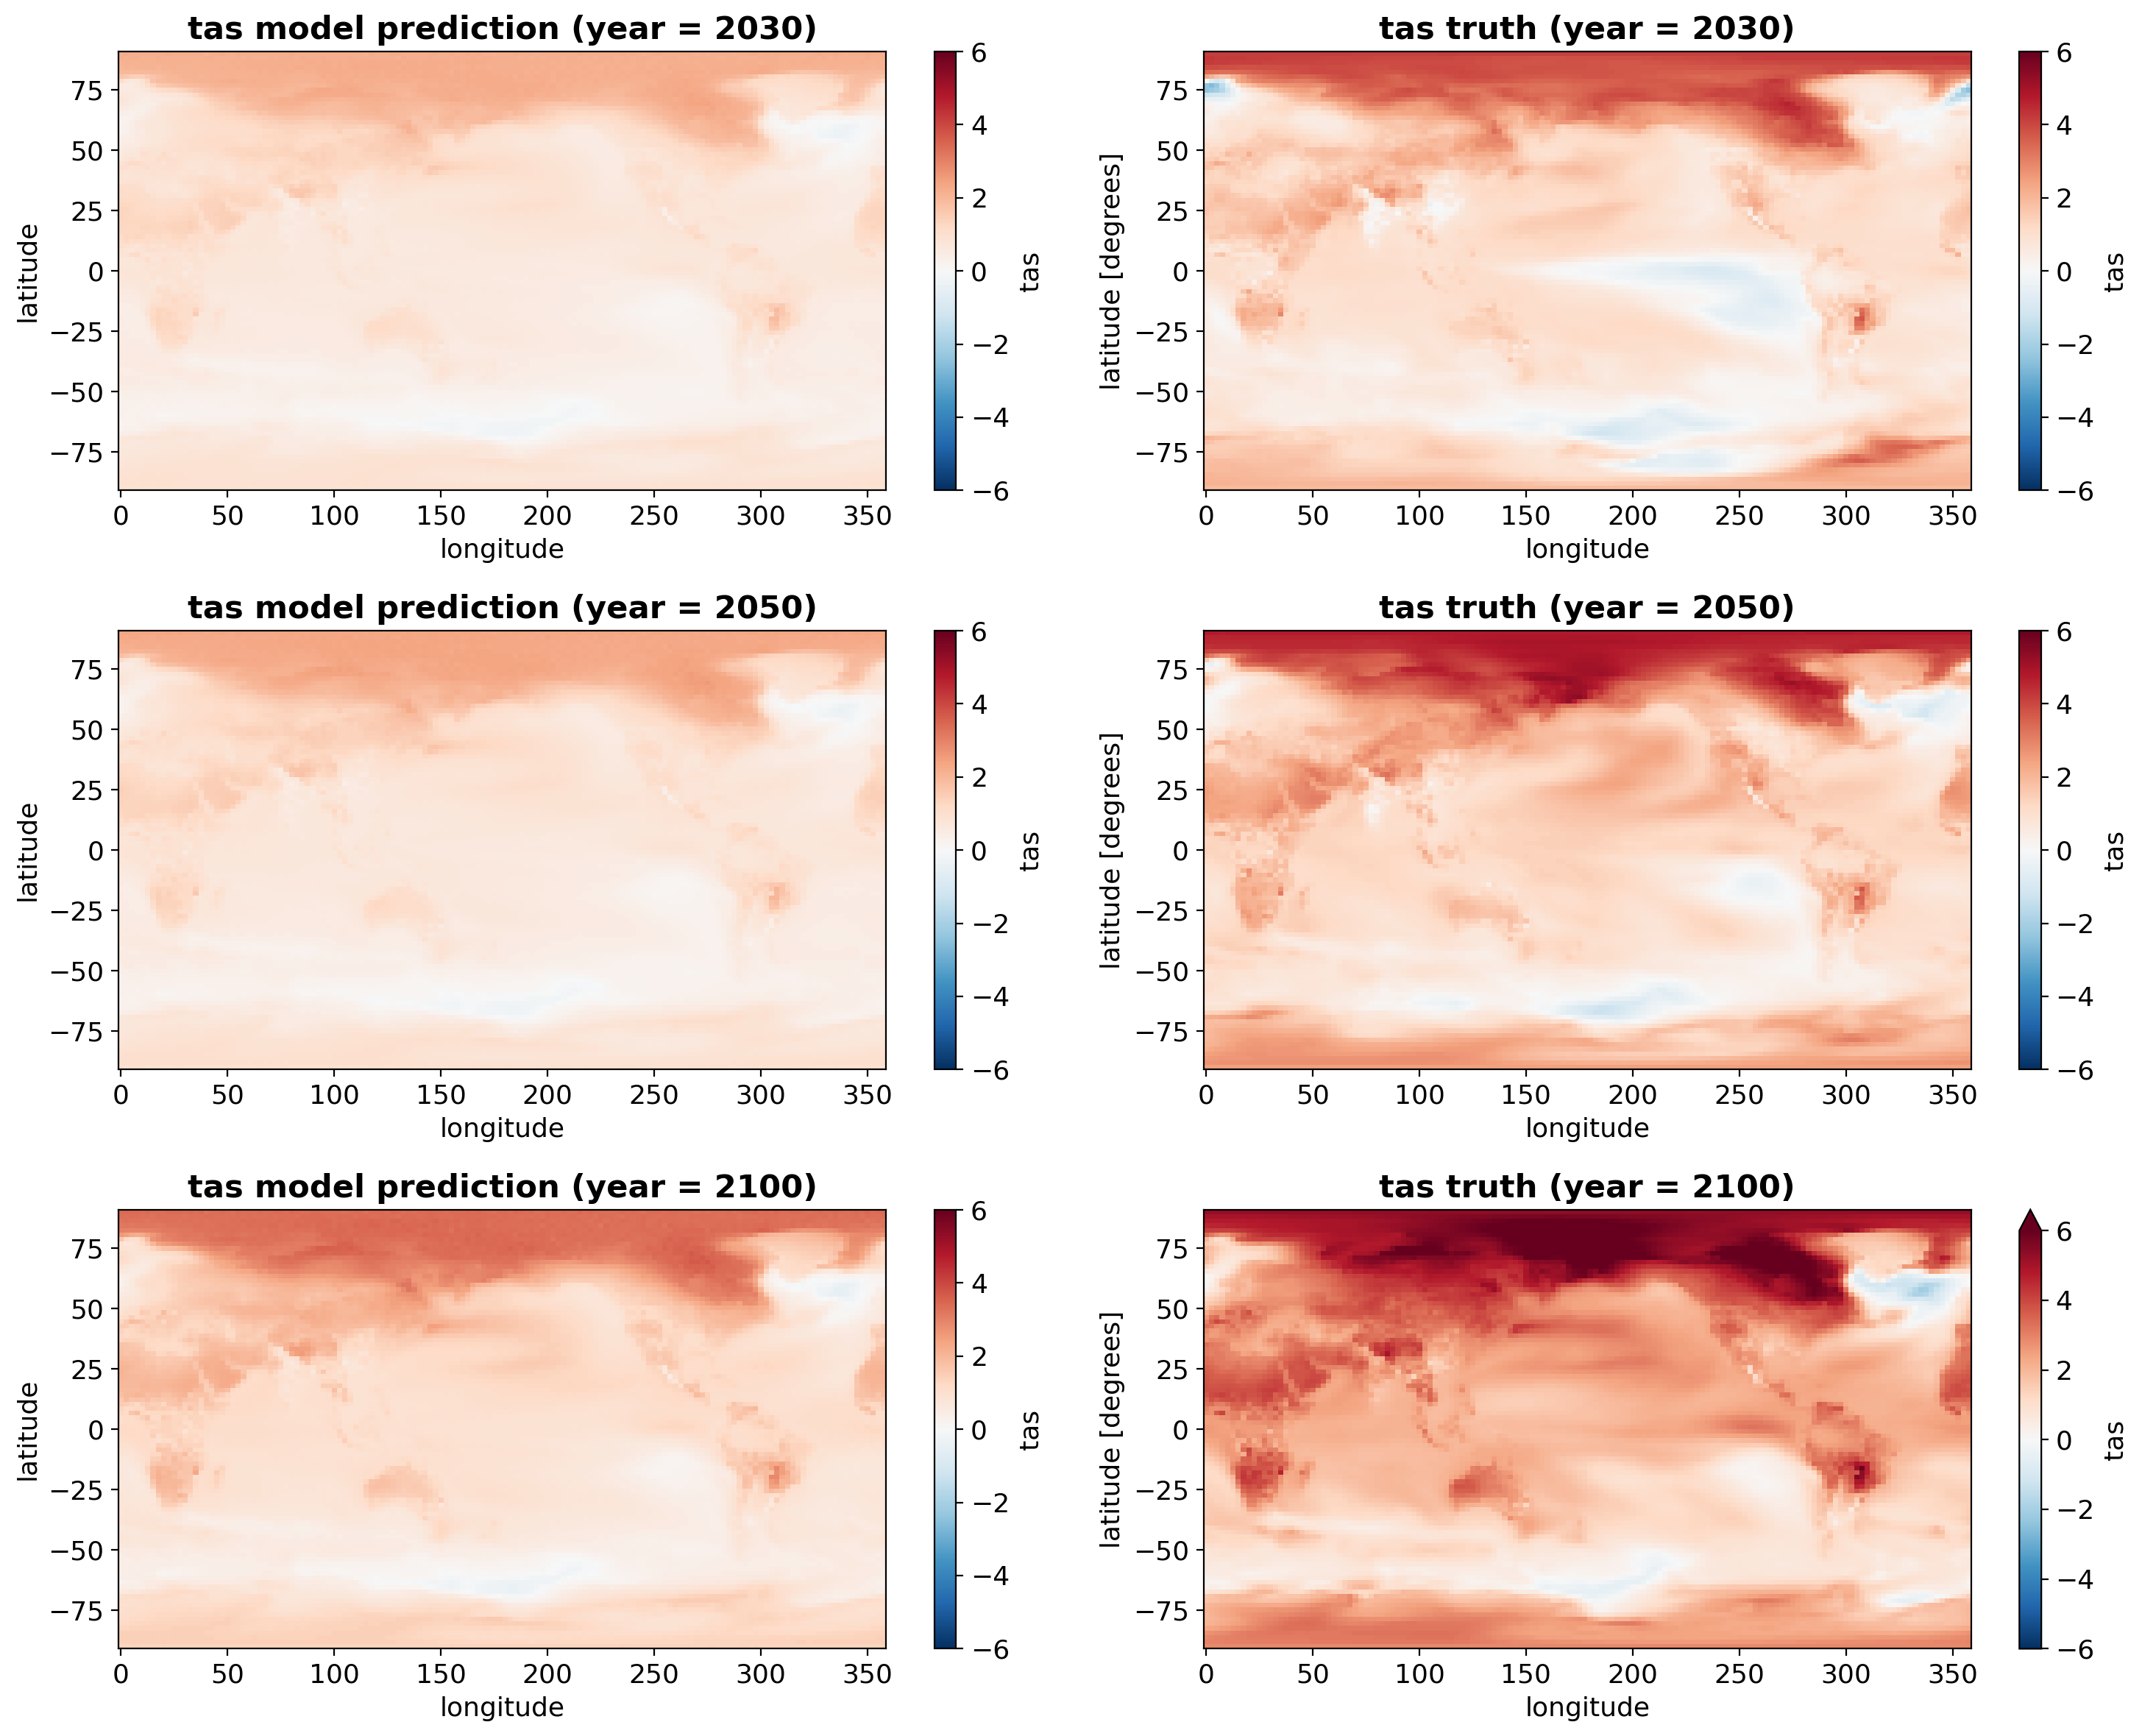

In [17]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()